In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

C:\Users\anton\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


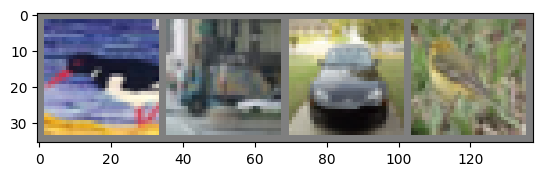

bird  truck car   bird 


In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')

Downloading: "https://github.com/facebookresearch/dino/archive/main.zip" to C:\Users\anton/.cache\torch\hub\main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_resnet50_pretrain/dino_resnet50_pretrain.pth" to C:\Users\anton/.cache\torch\hub\checkpoints\dino_resnet50_pretrain.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

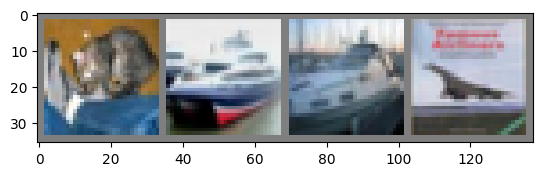

GroundTruth:  cat   ship  ship  plane


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
outputs = resnet50(images)

predicted = torch.argmax(outputs, 0)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  plane bird  plane plane
